In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv("atp_transformed/2000-2024 with covid.csv")

# Display first rows
df.head()

# Display dataframe info
df.info()

# Check for missing values
df.isnull().sum()

/var/folders/4p/pzg9jhn971xg0jxhjm2h4pd40000gn/T/ipykernel_21589/217506784.py:6: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("atp_transformed/2000-2024 with covid.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289980 entries, 0 to 1289979
Data columns (total 37 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   tourney_id               1289980 non-null  object 
 1   tourney_name             1289980 non-null  object 
 2   tourney_type             1289980 non-null  object 
 3   surface                  1289874 non-null  object 
 4   draw_size                1289980 non-null  int64  
 5   tourney_level            1289980 non-null  object 
 6   tourney_date             1289980 non-null  object 
 7   match_num                1289980 non-null  int64  
 8   score                    1289880 non-null  object 
 9   round_1                  1289810 non-null  object 
 10  round_2                  1284520 non-null  object 
 11  round_3                  433102 non-null   object 
 12  round_4                  25000 non-null    object 
 13  round_5                  6832 non-null    

tourney_id                       0
tourney_name                     0
tourney_type                     0
surface                        106
draw_size                        0
tourney_level                    0
tourney_date                     0
match_num                        0
score                          100
round_1                        170
round_2                       5460
round_3                     856878
round_4                    1264980
round_5                    1283148
best_of                          0
tourney_round                    0
minutes                     932434
player_id                        0
player_seed                 848643
player_name                      0
player_hand                     15
player_height               461641
player_country                   9
player_age                    4637
player_rank                 106382
player_rank_points          106539
ace                         920970
double_faults               920970
points_on_serve     



We are dropping the rounds and scores because we are "predicting a players future best ranking aka peak ATP rank"
So we need input features, because it describes their ability, form and performance up to now.

#round_1 -> round_5 Many matches are best of 3, which means round_4 - round_5 are empty. Some tournaments report detailed set scores and some don't.
#score gives the full score string, it's text and not structured. Parsing it into usable numbers will take a LOT of cleaning.

Why they don’t add much value to our use case
1. They describe only a single match outcome

We already have match_outcome win/loss and can aggregate win rates per surface, tournament, etc.
The actual set by set scores don’t help predict future peak rank as much as long-term performance trends.


Format:
put in format values of ground types here + other format values !!!!!!! <---------

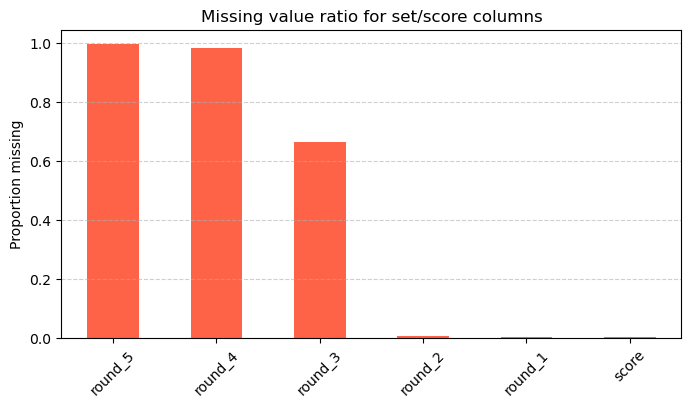

round_5    0.994704
round_4    0.980620
round_3    0.664257
round_2    0.004233
round_1    0.000132
score      0.000078
dtype: float64

In [16]:
cols = ['score','round_1','round_2','round_3','round_4','round_5']
missing = df[cols].isna().mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
missing.plot(kind='bar', color='tomato')
plt.title('Missing value ratio for set/score columns')
plt.ylabel('Proportion missing')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Plot to visualize missing data
missing


In [17]:

drop_cols = ['round_1','round_2','round_3','round_4','round_5','score', 'tourney_id', 'tourney_name','tourney_date', 'player_tourney_match_id']
df = df.drop(columns=drop_cols, errors='ignore')
# df['tourney_type'] = df['tourney_type'].replace({'matches': 1, 'futures': 2})
df['player_hand'] = df['player_hand'].replace({'L': 1, 'R': 2})

df.head()


,tourney_type,surface,draw_size,tourney_level,match_num,best_of,tourney_round,minutes,player_id,player_seed,...,ace,double_faults,points_on_serve,first_serve_in,1st_won,2nd_won,service_games,break_points_saved,break_points_faced,match_outcome
0,matches,Hard,32,A,1,3,R32,108.0,103163,1.0,...,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,1
1,matches,Hard,32,A,1,3,R32,108.0,101543,NaN,...,18.0,4.0,96.0,49.0,39.0,28.0,17.0,3.0,5.0,0
2,matches,Hard,32,A,2,3,R32,85.0,102607,NaN,...,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,1
3,matches,Hard,32,A,2,3,R32,85.0,102644,NaN,...,5.0,3.0,76.0,52.0,39.0,13.0,12.0,5.0,6.0,0
4,matches,Hard,32,A,3,3,R32,56.0,103252,NaN,...,0.0,0.0,55.0,35.0,25.0,12.0,8.0,1.0,1.0,1


Everything that is unknown or zero, we fill in the most common hand.

In [18]:
df['player_hand'].value_counts(dropna=False)


player_hand
2      973260
U      168498
1      147640
A         567
NaN        15
Name: count, dtype: int64

After cleaning, the player_hand column contains 973,260 right-handed, 147,640 left-handed, 567 ambidextrous, and 168,513 unknown entries.
Missing values 15 were filled with Unknown, resulting in a more complete categorical feature.

Also changed the string names of player_hand into numeric values so we can train a data model better.

In [19]:
# Handle player_hand column cleanly

# Create missing flag
df['player_hand_missing'] = df['player_hand'].isna().astype(int)

#  Fill missing values with 'U' (Unknown)
df['player_hand'] = df['player_hand'].fillna('U')

# Normalize all codes to readable text
df['player_hand'] = df['player_hand'].replace({
    'R': 'Right',
    'L': 'Left',
    'U': 'Unknown',
    'A': 'Ambidextrous'
})

df['player_hand'].head()

0    2
1    1
2    2
3    1
4    2
Name: player_hand, dtype: object

For minutes, we put it into three buckets. And we made a new column called match_length that has those three buckets. 
The match_lenght that had empty fields we put into 'common'. And we deleted the minutes column

In [20]:
#Count how many are missing (including blanks)
empty_minutes = df["minutes"].isna().sum() + (df["minutes"].astype(str).str.strip() == "").sum()
print(f"Empty or blank 'minutes': {empty_minutes}")

#Convert to numeric to ensure comparisons work
df["minutes"] = pd.to_numeric(df["minutes"], errors="coerce")

Empty or blank 'minutes': 932434


In [21]:
#Define the classifier function
def classify_match_length(x):
    if pd.isna(x):
        return np.nan
    elif x < 30:
        #short
        return 'short'  
    elif x <= 90:
        #medium
        return 'medium'  
    else:
        #long
        return 'long'  

In [22]:
# Create match_length column 
df["match_length"] = df["minutes"].apply(classify_match_length)

# Find the most common match length
most_common_length = df["match_length"].mode()[0]

# Fill missing values with the mode
df["match_length"] = df["match_length"].fillna(most_common_length)

# Move 'match_length' column after 'minutes'
minutes_index = df.columns.get_loc("minutes")
df.insert(minutes_index + 1, "match_length", df.pop("match_length"))


We want to fill in the missing values of player_height with the average. 

In [23]:
# Flag rows that were originally missing
df['player_height_missing'] = df['player_height'].isna().astype(int)

# Compute the mean (only from valid heights)
mean_height = df['player_height'].mean()
print(f"Mean height used for imputation: {mean_height:.2f} cm")

# Fill missing values with the mean height
df['player_height'] = df['player_height'].fillna(mean_height).round(0)

# Verify the result
print("Remaining NaNs:", df['player_height'].isna().sum())
print("Example values:\n", df[['player_height', 'player_height_missing']].head(10))


Mean height used for imputation: 184.35 cm
Remaining NaNs: 0
Example values:
    player_height  player_height_missing
0          188.0                      0
1          180.0                      0
2          190.0                      0
3          183.0                      0
4          175.0                      0
5          173.0                      0
6          183.0                      0
7          185.0                      0
8          180.0                      0
9          185.0                      0


In [24]:
# Flag rows that were originally missing
df['player_age_missing'] = df['player_age'].isna().astype(int)

# Compute the mean (only from valid heights)
mean_age = df['player_age'].mean()
print(f"Mean age used for imputation: {mean_age:.2f} age")

# Fill missing values with the mean height
df['player_age'] = df['player_age'].fillna(mean_age).round(0)

# Verify the result
print("Remaining NaNs:", df['player_age'].isna().sum())
print("Example values:\n", df[['player_height', 'player_age_missing']].head(10))


Mean age used for imputation: 23.84 age
Remaining NaNs: 0
Example values:
    player_height  player_age_missing
0          188.0                   0
1          180.0                   0
2          190.0                   0
3          183.0                   0
4          175.0                   0
5          173.0                   0
6          183.0                   0
7          185.0                   0
8          180.0                   0
9          185.0                   0


In [25]:
# Calculate means player rank
rank_mean = df["player_rank"].mean()
rank_points_mean = df["player_rank_points"].mean()

df["player_rank"] = df["player_rank"].fillna(rank_mean).round(0).astype(int)
df["player_rank_points"] = df["player_rank_points"].fillna(rank_points_mean).round(0).astype(int)

In [26]:
# Fill missing player_country with the most common country
most_common_country = df["player_country"].mode()[0]
df["player_country"] = df["player_country"].fillna(most_common_country)

In [27]:

# Fill missing surface with the most common surface
most_common_surface = df["surface"].mode()[0]
df["surface"] = df["surface"].fillna(most_common_surface)

In [29]:
missing_ratio = df.isna().mean().sort_values(ascending=False)
missing_ratio.head(15)


minutes                  0.722828
service_games            0.713944
break_points_faced       0.713941
break_points_saved       0.713941
2nd_won                  0.713941
1st_won                  0.713941
first_serve_in           0.713941
points_on_serve          0.713941
double_faults            0.713941
ace                      0.713941
player_seed              0.657873
tourney_type             0.000000
player_rank_points       0.000000
player_height_missing    0.000000
player_hand_missing      0.000000
dtype: float64

In [ ]:
# Choose one of the heavily-missing columns
column_to_check = 'points_on_serve'

# Calculate missing percentage per tourney_type
missing_by_tourney = (
    df.groupby('tourney_type')[column_to_check]
      .apply(lambda x: x.isna().mean() * 100)
      .sort_values(ascending=False)
)

print(f"Percentage of missing '{column_to_check}' by tourney_type:")
print(missing_by_tourney)


Percentage of missing 'points_on_serve' by tourney_type:
tourney_type
futures        100.000000
challengers     33.260723
matches          8.704243
Name: points_on_serve, dtype: float64


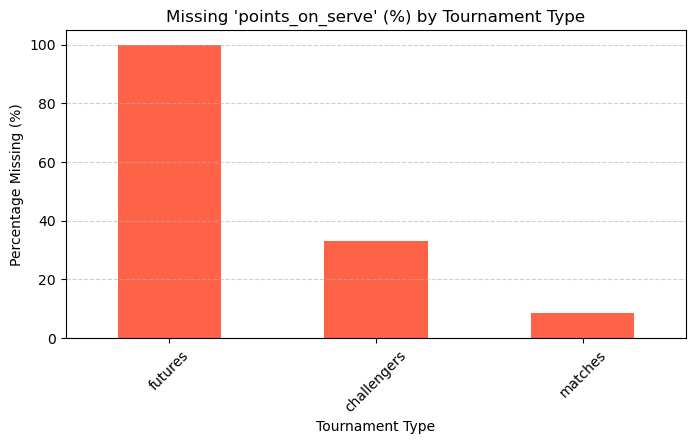

In [33]:
missing_by_tourney.plot(kind='bar', color='tomato', figsize=(8,4))
plt.title(f"Missing '{column_to_check}' (%) by Tournament Type")
plt.ylabel("Percentage Missing (%)")
plt.xlabel("Tournament Type")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [28]:
# open in data wrangler :)
df

# Save cleaned dataframe to new CSV (comment out to have it work)
# output_path = Path.cwd() / "atp_transformed" / "2000-2024_clean.csv"
# df.to_csv("atp_transformed/2000-2024_clean.csv", index=False)

,tourney_type,surface,draw_size,tourney_level,match_num,best_of,tourney_round,minutes,match_length,player_id,...,first_serve_in,1st_won,2nd_won,service_games,break_points_saved,break_points_faced,match_outcome,player_hand_missing,player_height_missing,player_age_missing
0,matches,Hard,32,A,1,3,R32,108.0,long,103163,...,49.0,39.0,28.0,17.0,3.0,5.0,1,0,0,0
1,matches,Hard,32,A,1,3,R32,108.0,long,101543,...,49.0,39.0,28.0,17.0,3.0,5.0,0,0,0,0
2,matches,Hard,32,A,2,3,R32,85.0,medium,102607,...,52.0,39.0,13.0,12.0,5.0,6.0,1,0,0,0
3,matches,Hard,32,A,2,3,R32,85.0,medium,102644,...,52.0,39.0,13.0,12.0,5.0,6.0,0,0,0,0
4,matches,Hard,32,A,3,3,R32,56.0,medium,103252,...,35.0,25.0,12.0,8.0,1.0,1.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289975,futures,Hard,32,15,401,3,SF,NaN,long,210011,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
1289976,futures,Hard,32,15,402,3,SF,NaN,long,209951,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
1289977,futures,Hard,32,15,402,3,SF,NaN,long,106168,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1289978,futures,Hard,32,15,501,3,F,NaN,long,209951,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
